In [1]:
import numpy as np
import pandas as pd
import datetime

In [2]:
from utils import *

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.dates import date2num
from itertools import cycle
markers = ['o', '.', '^', 'v', '<', '>', '8', 's', 'p', '*', 'D']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

def plot_ohlc(df_stock, time, open, close, low, high, volume):
    fig = plt.figure(figsize=(10,8))
    gs = gridspec.GridSpec(2,1,height_ratios=[3,1])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1], sharex=ax1)

    # Plot stock price (open, close, low, high)
    #target = returns_stock.set_index(time)[close]
    #target.plot(ax=ax1, drawstyle='steps-post', color=['black'])
    offset = pd.Timedelta(0.5, 'D')
    color = np.where(df_stock[open] > df_stock[close], '#F04730', '#2CA453')
    ax1.vlines(x=df_stock[time], ymin=df_stock[low], ymax=df_stock[high], color=color)
    ax1.hlines(y=df_stock[open], xmin=df_stock[time]-offset, xmax=df_stock[time], color=color)
    ax1.hlines(y=df_stock[close], xmin=df_stock[time], xmax=df_stock[time]+offset, color=color)
    ax1.set_xlim(df_stock[time].min(), df_stock[time].max())
    ax1.set_title('Osakekurssi, tavoite ja suositus')
    # Plot stock volumne
    ax2.vlines(x=df_stock[time], ymin=0, ymax=df_stock[volume], color='#00A2E8')
    ax2.set_yscale('log')
    ax2.set_ylim([df_stock[volume].min(), df_stock[volume].max()])
        
    return(ax1, ax2)

def plot_recs(intervals_stock, ax, rec, buy, sell):
    
    # Plot recommendation intervals
    now = pd.Timestamp(datetime.datetime.now().date())
    for suositus, color in zip(['Lisää', 'Vähennä', 'Osta', 'Myy', '-'],
                           ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:grey']):
        intervals_suositus = intervals_stock[intervals_stock[rec] == suositus]
        for (x1, x2) in zip(intervals_suositus[buy], intervals_suositus[sell]):
            ax1.axvspan(xmin=date2num(x1), xmax=date2num(x2), color=color, alpha=0.2)

def mcf_align(df_mcf1, df_mcf2):
    # The event times may differ, reindex both to all event times
    df_mcf1 = df_mcf1.set_index('Time')
    df_mcf2 = df_mcf2.set_index('Time')
    idx = df_mcf1.index.union(df_mcf2.index)
    # Fill forward overlapping MCFs
    # MCF1
    df_mcf1 = df_mcf1.reindex(idx)
    df_mcf1['dY'].fillna(value=0, inplace=True)
    df_mcf1['dC'].fillna(value=0, inplace=True)
    df_mcf1['Y'].fillna(method='ffill', inplace=True)
    df_mcf1['Y'].fillna(0, inplace=True)
    df_mcf1['C'].fillna(method='ffill', inplace=True)
    df_mcf1.loc[df_mcf1['Y'] == 0, 'C'] = np.nan #end of MCF
    df_mcf1.reset_index(inplace=True)
    # MCF 2
    df_mcf2 = df_mcf2.reindex(idx)
    df_mcf2['dY'].fillna(value=0, inplace=True)
    df_mcf2['dC'].fillna(value=0, inplace=True)
    df_mcf2['Y'].fillna(method='ffill', inplace=True)
    df_mcf2['Y'].fillna(0, inplace=True)
    df_mcf2['C'].fillna(method='ffill', inplace=True)
    df_mcf2.loc[df_mcf2['Y'] == 0, 'C'] = np.nan #end of MCF
    df_mcf2.reset_index(inplace=True)
    return(df_mcf1, df_mcf2)

def mcf_diff(fr_sample1, fr_sample2, 
             sample1='Sample', time1='Time', events1='dY', values1='dC', 
             sample2='Sample', time2='Time', events2='dY', values2='dC', 
             include_lowest=False, bootstrap=None, save_bootstrap=False, level=0.05):
    
    df_mcf1 = mcf(fr_sample1, time=time1, sample=sample1, events=events1, values=values1, include_lowest=include_lowest)
    df_mcf2 = mcf(fr_sample2, time=time2, sample=sample2, events=events2, values=values2, include_lowest=include_lowest)
    df_mcf1, df_mcf2 = mcf_align(df_mcf1, df_mcf2)

    # Calculate difference in returns and total observable
    time = df_mcf1['Time'] # should be equal
    dC_diff = df_mcf1['dC'] - df_mcf2['dC']
    C_diff = df_mcf1['C'] - df_mcf2['C']
    dY = df_mcf1['dY'] + df_mcf2['dY'] 
    Y = np.minimum(df_mcf1['Y'], df_mcf2['Y'])
    df_diff = pd.DataFrame({'Time': time, 'dY':dY, 'Y': Y, 'dC':dC_diff, 'C': C_diff})
    
    # Calculate MCF diffs from bootstrap replicates
    if not bootstrap is None:
        mcfs = {}
        instances1 = fr_sample1[sample1].drop_duplicates()
        instances2 = fr_sample2[sample2].drop_duplicates()
        for i in range(bootstrap):
            # Take an equal size samples from originals with replacement
            fr_bootstrap1 = instances1.sample(frac=1, replace=True)
            fr_bootstrap1['BootstrapSample'] = np.arange(len(fr_bootstrap1))
            fr_bootstrap1 = fr_bootstrap1.merge(fr_sample1)
            fr_bootstrap2 = instances2.sample(frac=1, replace=True)
            fr_bootstrap2['BootstrapSample'] = np.arange(len(fr_bootstrap2))
            fr_bootstrap2 = fr_bootstrap2.merge(fr_sample2)            
            df_bootstrap = mcf_diff(fr_bootstrap1, fr_bootstrap2, include_lowest=include_lowest,
                                    time1=time1, sample1='BootstrapSample', events1=events1, values1=values1,
                                    time2=time2, sample2='BootstrapSample', events2=events2, values2=values2)
            _, df_bootstrap = mcf_align(df_diff, df_bootstrap)
            mcfs['C.{}'.format(i)] = df_bootstrap.set_index('Time')['C']
        mcfs = pd.DataFrame(mcfs)
        # Calculate quantiles
        df_diff['C Lower'] = mcfs.apply(lambda means: np.quantile(means, level/2), axis=1) 
        df_diff['C Upper'] = mcfs.apply(lambda means: np.quantile(means, 1 - level/2), axis=1)
        if save_bootstrap:
            df_diff = pd.concat((df_diff, mcfs), axis=1)
        
    return(df_diff)

def mcf(fr_sample, sample='Sample', time='Time', events='dY', values='dC', extras=[],
         include_lowest=False, bootstrap=None, save_bootstrap=False, level=0.05, add_cost=0.00):
    df_sample = pd.DataFrame(fr_sample[sample])
    # Calculate if the sample is observable at each time points
    df_sample['Time'] = fr_sample[time]
    df_sample['dY'] = fr_sample[events]
    df_sample['Yi'] = df_sample.groupby(sample)['dY'].cumsum()
    df_sample['Yi'] = df_sample.groupby(sample)['Yi'].shift(1).fillna(0)
    # Whether to include the return at entry: left interval open or closed
    df_sample['dY0i'] = (fr_sample[values].notnull() & (fr_sample[events] == 1)).astype(int)
    if include_lowest:
        df_sample['Yi'] = df_sample['Yi'] + df_sample['dY0i']
    # Caclulate the return of the sample at each time point
    df_sample['dC'] = df_sample['Yi'] * fr_sample[values]
    for col in extras:
        df_sample[col] = df_sample['Yi'] * fr_sample[col]
    
    if add_cost > 0.00:
        df_sample.loc[fr_sample[events] > 0, 'dC'] = 0.0
        df_sample.loc[fr_sample[events] != 0, 'dC'] -= add_cost
    
    # Calculate the total return and the total number of observable at each time point
    df = df_sample.groupby('Time')[['dC', 'dY', 'dY0i'] + extras].agg('sum').sort_index().reset_index()
    df['Y'] = df['dY'].cumsum().shift(1).fillna(0)
    if include_lowest:
        df['Y'] = df['Y'] + df['dY0i']
    # MCF: Calculate the mean return and cumulative return at each time point 
    df['dC'] = np.where(df['Y'] > 0, df['dC']/df['Y'], 0.0)
    df['C'] = (1+df['dC']).cumprod()
    for col in extras:
        df[col] = np.where(df['Y'] > 0, df[col]/df['Y'], 0.0)
    #df.drop('dY0i', axis=1, inplace=True)
    df = df[['Time', 'dY', 'dC', 'Y', 'C'] + extras]
    
    # Recalculate MCFs from bootstrap replicates
    if not bootstrap is None:
        mcfs = {}
        instances = fr_sample[sample].drop_duplicates()
        for i in range(bootstrap):
            # Take an equal size sample from original with replacement
            fr_bootstrap = instances.sample(frac=1, replace=True)
            fr_bootstrap['BootstrapSample'] = np.arange(len(fr_bootstrap))
            fr_bootstrap = fr_bootstrap.merge(fr_sample)
            # Calculate and save MCF from this sample
            df_bootstrap = mcf(fr_bootstrap, sample='BootstrapSample', time=time, events=events, values=values,
                               include_lowest=include_lowest, bootstrap=None, extras=extras)
            _, df_bootstrap = mcf_align(df, df_bootstrap)
            mcfs['C.{}'.format(i)] = df_bootstrap.set_index('Time')['C']
        mcfs = pd.DataFrame(mcfs)
        # Calculate quantiles
        df['C Lower'] = mcfs.apply(lambda means: np.quantile(means, level/2), axis=1) 
        df['C Upper'] = mcfs.apply(lambda means: np.quantile(means, 1 - level/2), axis=1) 
        if save_bootstrap:
            df = pd.concat((df, mcfs), axis=1)
    
    #extra_cols = [] if bootstrap is None else ['C Lower', 'C Upper']
    return(df)

def plot_mcf(fr, axs=None, label='', color='black', marker='.', drawstyle='steps-post',
              CI=True, xmin=None, xmax=None, ymin=None, ymax=None):

    # If no axis were given, create a new figure
    if axs is None:
        fig = plt.figure(figsize=(8,6))
        gs = gridspec.GridSpec(2,1,height_ratios=[3,1])
        ax = fig.add_subplot(gs[0])
        axx = fig.add_subplot(gs[1], sharex=ax)
    else:
        ax, axx = axs

    # Plot MCF
    has_values, has_censor = fr['dC'] > 0, fr['dY'] < 0
    ax.plot(fr.loc[has_values, 'Time'].values, fr.loc[has_values, 'C'].values, marker=marker, linestyle='', color=color, label=label)
    ax.plot(fr.loc[has_censor, 'Time'].values, fr.loc[has_censor, 'C'].values, marker='+' if marker else '', linestyle='', color=color, label='')
    ax.plot(fr['Time'].values, fr['C'].values, marker='', linestyle='-', drawstyle=drawstyle, color=color, label='')
    if CI and ('C Lower' in fr) and ('C Upper' in fr):
        ax.plot(fr['Time'].values, fr['C Lower'].values, marker='', linestyle='--', drawstyle=drawstyle, color=color, label='')
        ax.plot(fr['Time'].values, fr['C Upper'].values, marker='', linestyle='--', drawstyle=drawstyle, color=color, label='')

    ax.set_title('Mean Cumulative Function Plot')
    ax.set_ylabel('E[C]')
    if label:
        ax.legend()
    ax.grid(True)

    # Plot Observable
    axx.plot(fr['Time'].values, fr['Y'].values, drawstyle=drawstyle, color=color, label='')
    axx.set_ylabel('Observable')
    axx.set_xlabel('Time')
    axx.grid()

    # By default expand the plot to match the data
    ax_xmin = fr['Time'].min()
    ax_xmax = fr['Time'].max()
    ax_ymin = (fr['C Lower'].min() if 'C Lower' in fr else fr['C'].min()) - 0.01
    ax_ymax = (fr['C Upper'].max() if 'C Upper' in fr else fr['C'].max()) + 0.01
    ax_yobsmin = fr['Y'].min() 
    ax_yobsmax = fr['Y'].max()  + 1
    # update
    if not axs is None:
        # mcf x axis
        old_xmin, old_xmax = ax.get_xlim()
        ax.set_xlim(ax_xmin, ax_xmax)
        new_xmin, new_xmax = ax.get_xlim()
        ax_xmin, ax_xmax = min(old_xmin, new_xmin), max(old_xmax, new_xmax)
        # mcf y axis
        old_ymin, old_ymax = ax.get_ylim()
        ax.set_ylim(ax_ymin, ax_ymax)
        new_ymin, new_ymax = ax.get_ylim()
        ax_ymin, ax_ymax = min(old_ymin, new_ymin), max(old_ymax, new_ymax)
        # observable
        old_yobsmin, old_yobsmax = axx.get_ylim()
        axx.set_ylim(ax_yobsmin, ax_yobsmax)
        new_yobsmin, new_yobsmax = axx.get_ylim()
        ax_yobsmin, ax_yobsmax = min(old_yobsmin, new_yobsmin), max(old_yobsmax, new_yobsmax)
    # Overwrite if given
    ax_xmin = xmin if not xmin is None else ax_xmin
    ax_xmax = xmax if not xmax is None else ax_xmax
    ax_ymin = ymin if not ymin is None else ax_ymin
    ax_ymax = ymax if not ymax is None else ax_ymax
    # set
    ax.set_xlim(ax_xmin, ax_xmax)
    ax.set_ylim(ax_ymin, ax_ymax)
    axx.set_ylim(ax_yobsmin, ax_yobsmax)
    
    
    return (ax,axx)

def plot_mcfs(group_fr, axs=None, subplots=False, **kwargs):
    # Plot timelines grouped by cohorts
    idx, marker, color = 0, cycle(markers), cycle(colors)
    for cohort, cohort_fr in group_fr:
        mcf_kwargs = kwargs
        if not 'color' in kwargs: mcf_kwargs = {**mcf_kwargs, **{'color': next(color)}}
        if not 'marker' in kwargs: mcf_kwargs = {**mcf_kwargs, **{'marker': next(marker)}}
        axs = plot_mcf(cohort_fr, axs, label=str(cohort) if cohort else '', **mcf_kwargs)
        if subplots: axs = None

    return axs

### Recommendations data

In [11]:
# Read recommendations with match to stock and trading day in price data
recommendations = match_recommendations_prices(fn_recommendations="analysis.csv", fn_prices="prices.csv", verbose=True)

Kauppalehti tickers missing from merge file: {'FIA1SN0123'}
Inderes stock missing kauppalehti ticker: {'hm', 'movinn', 'agillic', 'astralis', 'cibus-nordic-real-estate', 'mgi-media-and-games-invest', 'ascelia-pharma', 'nibe-industrier'}
Recommendations without matching closing price:
[('Kesko B', '2013-10-23'), ('Suominen', '2013-10-24'), ('Raute A', '2013-10-31'), ('Suominen', '2014-05-27'), ('Oriola B', '2014-07-17'), ('Ahtium', '2014-11-07'), ('Martela A', '2017-11-27'), ('WithSecure', '2019-07-22'), ('EAB Group', '2022-10-02'), ('Panostaja', '2023-11-23')]


In [12]:
recommendations.head()

,Osake,PvmSuositus,Suositus,Analyytikko,url,Päivämäärä
0,Aallon Group,2019-04-09,Vähennä,Atte Riikola,https://www.inderes.fi/fi/uusi-haastaja-defens...,2019-04-09
1,Aallon Group,2019-08-23,Vähennä,Atte Riikola,https://www.inderes.fi/fi/yritysostoja-odotell...,2019-08-23
2,Aallon Group,2019-09-30,Vähennä,Atte Riikola,https://www.inderes.fi/fi/ensimmainen-pieni-as...,2019-09-30
3,Aallon Group,2019-12-12,Vähennä,Atte Riikola,https://www.inderes.fi/fi/yritysostostrategia-...,2019-12-12
4,Aallon Group,2020-02-14,Lisää,Atte Riikola,https://www.inderes.fi/fi/otamme-riskin-ja-luo...,2020-02-14


### Price data

In [13]:
prices = get_prices(fn_prices="prices.csv")
prices.head()

,Osake,Päivämäärä,Vaihto €,Ylin,Alin,Keskimäärin,Päätöskurssi,Päätöskurssi + Osinko,Tuotto (%),Alin (%),Ylin (%),Index (%),Index
0,Aallon Group,2019-04-09,203301.17,8.900,8.461,8.6390,8.600,8.600,NaN,-0.016163,0.034884,0.000478,2.414071
1,Aallon Group,2019-04-10,98816.07,8.601,8.465,8.5599,8.465,8.465,-0.015698,0.000000,0.016066,0.003594,2.422747
2,Aallon Group,2019-04-11,51261.80,8.500,8.350,8.4828,8.500,8.500,0.004135,-0.017647,0.000000,0.004140,2.432776
3,Aallon Group,2019-04-12,27236.50,8.550,8.350,8.5141,8.500,8.500,0.000000,-0.017647,0.005882,-0.001215,2.429821
4,Aallon Group,2019-04-15,13644.50,8.600,8.500,8.5385,8.500,8.500,0.000000,0.000000,0.011765,0.001547,2.433580


### Add information

In [14]:
add_information(recommendations, prices, extras=False).head()

,Osake,PvmSuositus,Suositus,Analyytikko,url,Päivämäärä,Edellinen
0,Aallon Group,2019-04-09,Vähennä,Atte Riikola,https://www.inderes.fi/fi/uusi-haastaja-defens...,2019-04-09,-
1,Aallon Group,2019-08-23,Vähennä,Atte Riikola,https://www.inderes.fi/fi/yritysostoja-odotell...,2019-08-23,Vähennä
2,Aallon Group,2019-09-30,Vähennä,Atte Riikola,https://www.inderes.fi/fi/ensimmainen-pieni-as...,2019-09-30,Vähennä
3,Aallon Group,2019-12-12,Vähennä,Atte Riikola,https://www.inderes.fi/fi/yritysostostrategia-...,2019-12-12,Vähennä
4,Aallon Group,2020-02-14,Lisää,Atte Riikola,https://www.inderes.fi/fi/otamme-riskin-ja-luo...,2020-02-14,Vähennä


### Counting process returns

In [20]:
buysell = prices.groupby('Osake', as_index=False)['Päivämäärä'].agg(['min', 'max']).rename(columns={'min':'Buy', 'max':'Sell'})
returns = to_counting_process(buysell, prices)

In [21]:
recommendations1 = recommendation_ith(recommendations)
returns1 = to_counting_process(recommendations1, prices, id_vars=['Osake', 'N'])

In [22]:
recommendations2 = recommendation_nth(recommendations)
returns2 = to_counting_process(recommendations2, prices, id_vars=['Osake', 'N'])

### Recommedation intervals

In [23]:
interval1 = add_interval_returns(recommendations1, prices)
interval1 = add_Xday_returns(interval1, prices)
interval1[(interval1['Suositus'] != '-')].to_csv('assets/interval1.csv', index=False)

In [24]:
interval2 = add_interval_returns(recommendations2, prices)
interval2.to_csv('assets/interval2.csv', index=False)

## MCF

### Index

In [25]:
#df_mcf = {}
#for rec, returns_rec in returns2.groupby("Suositus"): 
#    df_mcf[(False, rec)] = mcf(returns_rec, sample='Osake', time='Päivämäärä', values='Tuotto (%)', include_lowest=False)
#    df_mcf[(True, rec)] = mcf(returns_rec, sample='Osake', time='Päivämäärä', values='Tuotto (%)', include_lowest=True)
#df_mcf[(False, "Indeksi")] = mcf(returns, sample='Osake', time='Päivämäärä', values='Tuotto (%)', include_lowest=False)
#df_mcf[(True, "Indeksi")] = mcf(returns, sample='Osake', time='Päivämäärä', values='Tuotto (%)', include_lowest=True)
#df_mcf = pd.concat(df_mcf, names=["Suositus", "Row"]).reset_index()

In [26]:
mcfs = {(False, "Indeksi"): mcf(returns, sample='Osake', time='Päivämäärä', values='Tuotto (%)', include_lowest=False)} |\
       {(True, "Indeksi"): mcf(returns, sample='Osake', time='Päivämäärä', values='Tuotto (%)', include_lowest=True)} |\
       {(False, rec): mcf(returns_rec, sample='Osake', time='Päivämäärä', values='Tuotto (%)', include_lowest=False) 
        for rec, returns_rec in returns2.groupby("Suositus")} |\
       {(True, rec): mcf(returns_rec, sample='Osake', time='Päivämäärä', values='Tuotto (%)', include_lowest=True) 
        for rec, returns_rec in returns2.groupby("Suositus")}
mcfs = pd.concat(mcfs, names=["Inderes", "Suositus", "Row"]).reset_index()
mcfs[mcfs['Suositus'] != '-'].to_csv('assets/mcf_portfolio.csv', index=False)

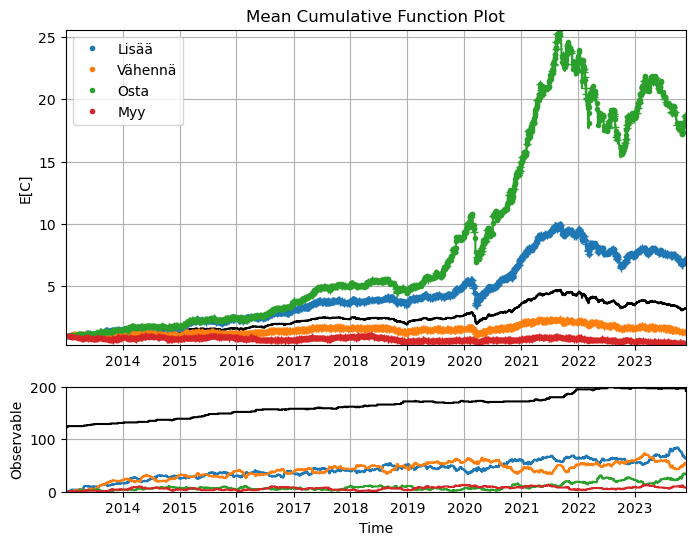

In [27]:
# MCF plots
recs= ['Lisää', 'Vähennä', 'Osta', 'Myy']
axs = plot_mcf(mcfs[(mcfs['Suositus'] == 'Indeksi') & ~mcfs['Inderes']], color='black', marker='')
plot_mcfs([(rec, mcfs[(mcfs['Suositus'] == rec) & ~mcfs['Inderes']]) for rec in recs], CI=False, axs=axs, marker='.');

In [28]:
prod_all = lambda s:(1+s).prod()-1
returns_365d = mcfs[~mcfs['Inderes']].groupby("Suositus").rolling('365D', on="Time", min_periods=1)["dC"].apply(prod_all)
returns_365d= returns_365d.reset_index()
# Add right column with index return each day
mcf_index = returns_365d.loc[returns_365d["Suositus"] == "Indeksi", ['Time', 'dC']]
returns_365d = returns_365d.merge(mcf_index, on="Time", how="left", suffixes=("", ".Indeksi"))
returns_365d["dC.diff"] = returns_365d["dC"] - returns_365d["dC.Indeksi"]

Text(0.5, 1.0, '365D rolling difference to index')

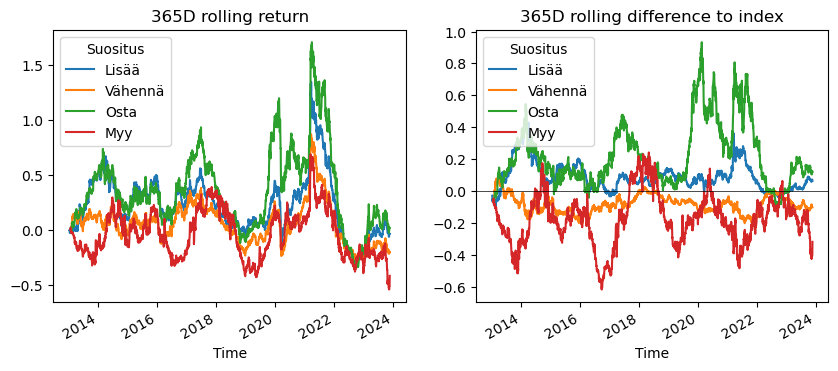

In [29]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
returns_365d.pivot(index='Time', columns='Suositus', values='dC')[['Lisää', 'Vähennä', 'Osta', 'Myy']].plot(ax=ax1)
returns_365d.pivot(index='Time', columns='Suositus', values='dC.diff')[['Lisää', 'Vähennä', 'Osta', 'Myy']].plot(ax=ax2)
ax2.axhline(0, color='black', linewidth=0.5)
ax1.set_title("365D rolling return")
ax2.set_title("365D rolling difference to index")

### Nth recommendation

In [30]:
# use returns2 to model recommendation change, i.e. new recommendation != old recommendation

In [31]:
mcfs = {(False, "Kaikki", "Kaikki"): mcf(returns1, sample='Osake', time='Päivä', values='Tuotto (%)', include_lowest=False,
                                        extras=['Alin (%)', 'Ylin (%)'])} |\
       {(False, "Kaikki") + rec: mcf(returns_rec, sample='Osake', time='Päivä', values='Tuotto (%)', include_lowest=False,
                                    extras=['Alin (%)', 'Ylin (%)'])
        for rec, returns_rec in returns1.groupby(['Suositus'])} |\
       {(True, "Kaikki", "Kaikki"): mcf(returns1, sample='Osake', time='Päivä', values='Tuotto (%)', include_lowest=True,
                                       extras=['Alin (%)', 'Ylin (%)'])} |\
       {(True, "Kaikki") + rec: mcf(returns_rec, sample='Osake', time='Päivä', values='Tuotto (%)', include_lowest=True,
                                   extras=['Alin (%)', 'Ylin (%)'])
        for rec, returns_rec in returns1.groupby(['Suositus'])} |\
       {(False,) + rec + ("Kaikki",): mcf(returns_rec, sample='Osake', time='Päivä', values='Tuotto (%)', include_lowest=False,
                                         extras=['Alin (%)', 'Ylin (%)'])
        for rec, returns_rec in returns1.groupby(['Edellinen'])} |\
       {(False,) + rec: mcf(returns_rec, sample='Osake', time='Päivä', values='Tuotto (%)', include_lowest=False,
                           extras=['Alin (%)', 'Ylin (%)'])
        for rec, returns_rec in returns1.groupby(['Edellinen', 'Suositus'])} |\
       {(True,) + rec + ("Kaikki",): mcf(returns_rec, sample='Osake', time='Päivä', values='Tuotto (%)', include_lowest=False,
                                        extras=['Alin (%)', 'Ylin (%)'])
        for rec, returns_rec in returns1.groupby(['Edellinen'])} |\
       {(True,) + rec: mcf(returns_rec, sample='Osake', time='Päivä', values='Tuotto (%)', include_lowest=True,
                          extras=['Alin (%)', 'Ylin (%)'])
        for rec, returns_rec in returns1.groupby(['Edellinen', 'Suositus'])} 
mcfs = pd.concat(mcfs, names=["Inderes", "Edellinen", "Suositus", "Row"]).reset_index()
mcfs[(mcfs['Time'] <= 120) & (mcfs['Suositus'] != '-')].to_csv('assets/mcf_recommendation.csv', index=False)

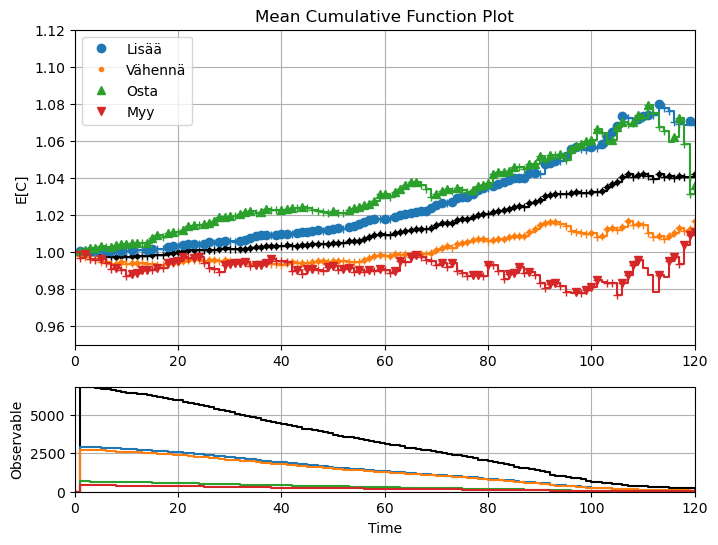

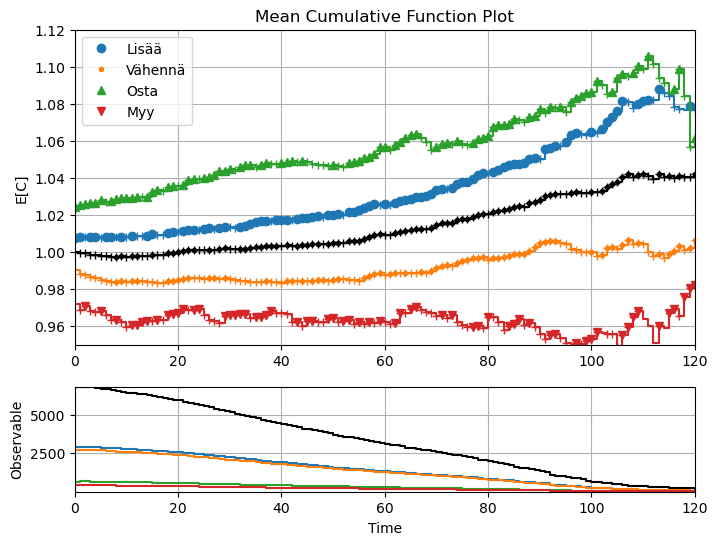

In [32]:
# MCF plots
recs= ['Lisää', 'Vähennä', 'Osta', 'Myy']
axs = plot_mcf(mcfs[(mcfs['Edellinen'] == 'Kaikki') & (mcfs['Suositus'] == 'Kaikki') & ~mcfs['Inderes']], xmax=120, ymax=1.075, ymin=0.995)
plot_mcfs([(rec, mcfs[(mcfs['Edellinen'] == 'Kaikki') & (mcfs['Suositus'] == rec) & ~mcfs['Inderes']]) for rec in recs], CI=False, xmax=120, ymax=1.12, ymin=0.95, axs=axs);

# MCF plots
recs= ['Lisää', 'Vähennä', 'Osta', 'Myy']
axs = plot_mcf(mcfs[(mcfs['Edellinen'] == 'Kaikki') & (mcfs['Suositus'] == 'Kaikki') & mcfs['Inderes']], xmax=120, ymax=1.075, ymin=0.995)
plot_mcfs([(rec, mcfs[(mcfs['Edellinen'] == 'Kaikki') & (mcfs['Suositus'] == rec) & mcfs['Inderes']]) for rec in recs], CI=False, xmax=120, ymax=1.12, ymin=0.95, axs=axs);

### DCF

In [33]:
def mcf_dcf(fr):
    n = len(fr)
    s = fr.groupby('Time')['Tuotto Inderes (%)'].apply(lambda s: (s + 1).sum()) / n
    return (s)

In [34]:
def mcf_dcf_index(fr):
    n = len(fr)
    s = fr.groupby('Time')['Tuotto Index (%)'].apply(lambda s: (s + 1).sum()) / n
    return (s)

(0.0, 365.0)

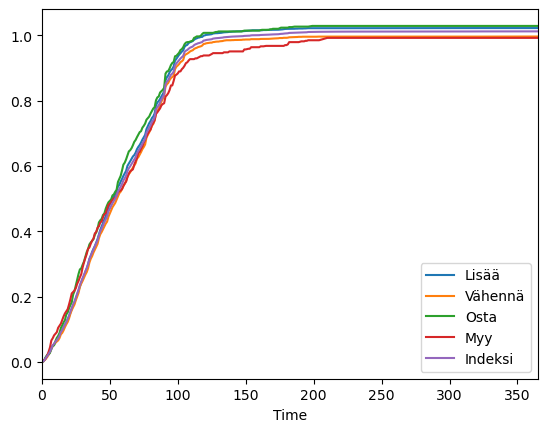

In [35]:
df_mcf = mcf_dcf_index(interval1).rename("Indeksi")
df_mcfs = interval1.groupby('Suositus').apply(mcf_dcf).unstack(level=0, fill_value=0)
df_mcfs = pd.concat([df_mcf, df_mcfs], axis=1)
ax = df_mcfs[recs+["Indeksi"]].cumsum().plot()
ax.set_xlim(0,365)

In [36]:
from scipy.optimize import newton, bisect

def compute_profit(cashflow, time):
    dcf = lambda d: (cashflow / (1.0 + d)**time).mean() - 1
    try:
        z = newton(dcf, 0.00, maxiter=1000)
    except (ValueError, RuntimeError) as e:
        z = np.nan
    return(z)


In [37]:
pd.DataFrame({
    'Tuotto Inderes (%)' : interval2.groupby('Suositus').apply(lambda trade: compute_profit(trade['Tuotto Inderes (%)'] + 1, trade['Time']/365.0)),
    'Tuotto Index (%)' : interval2.groupby('Suositus').apply(lambda trade: compute_profit(trade['Tuotto Index (%)'] + 1, trade['Time']/365.0)),
    'Tuotto Difference (%)' : interval2.groupby('Suositus').apply(lambda trade: compute_profit(trade['Tuotto Inderes (%)'] - trade['Tuotto Index (%)'] + 1, trade['Time']/365.0)),
    'Tuotto Difference+ (%)' : interval2.groupby('Suositus').apply(lambda trade: compute_profit(trade['Tuotto Inderes (%)'] + trade['Inderes (%)'] - trade['Tuotto Index (%)'] - trade['Index (%)'] + 1, trade['Time']/365.0))
}).loc[['Osta', 'Lisää', 'Vähennä', 'Myy'],]


,Tuotto Inderes (%),Tuotto Index (%),Tuotto Difference (%),Tuotto Difference+ (%)
Suositus,,,,
Osta,0.231814,0.075840,0.144948,0.321878
Lisää,0.180588,0.101386,0.078102,0.103596
Vähennä,-0.006189,0.104676,-0.118796,-0.155192
Myy,-0.027267,0.134185,-0.160304,-0.244602


In [38]:
#interval2.groupby(['Suositus', 'Vuosi']).apply(
#    lambda trade: compute_profit(trade['Tuotto Inderes (%)'] + trade['Inderes (%)'] - \
#                                 trade['Tuotto Index (%)'] - trade['Index (%)'] + 1, trade['Time']/365.0)
#).unstack(level=1).loc[['Osta', 'Lisää', 'Vähennä', 'Myy'],]

C:\Users\mvil4\AppData\Local\Temp\ipykernel_18384\459566123.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ax = diff.unstack(level=0).fillna(method='bfill')[['Lisää', 'Vähennä', 'Osta', 'Myy']].plot()


(-0.6, 1.2)

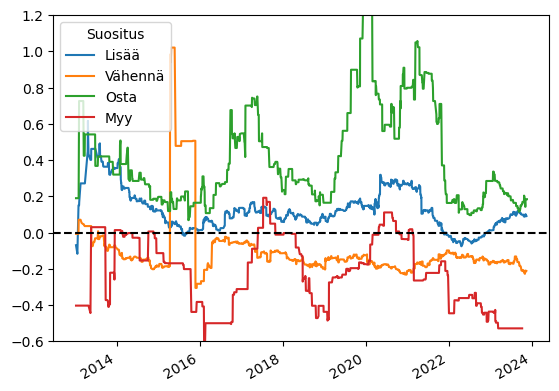

In [39]:
dcf = lambda trade: compute_profit(trade['Tuotto Inderes (%)'] + trade['Inderes (%)'] - \
                                   trade['Tuotto Index (%)'] - trade['Index (%)'] + 1, trade['Time']/365.0)

def get_rolling_dcf(interval, time_delta=365):
    interval_t = interval.set_index('Buy').sort_index()
    diff = {}
    for end, df in interval_t.iterrows():
        start = end - pd.Timedelta(time_delta, 'D')
        trade = interval_t.loc[start:end,:]
        diff[end] = dcf(trade)
    return(pd.Series(diff))

diff = interval2.groupby('Suositus').apply(get_rolling_dcf)
ax = diff.unstack(level=0).fillna(method='bfill')[['Lisää', 'Vähennä', 'Osta', 'Myy']].plot()
ax.axhline(0, linestyle='dashed', color='black')
ax.set_ylim(-0.6,1.2)

### 365 days from recommendation

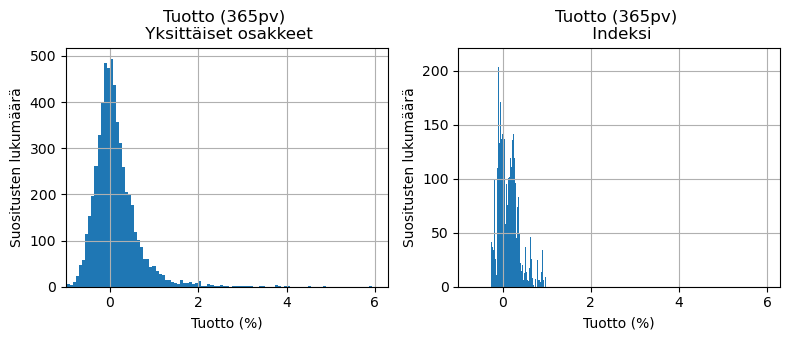

In [42]:
fig, (ax, axx) = plt.subplots(1,2, sharex=True, figsize=(8,3.5))
# Stock
interval1['Tuotto Inderes 365d (%)'].hist(ax=ax, bins=100)
ax.set_title('Tuotto (365pv) \n Yksittäiset osakkeet')
ax.set_xlabel('Tuotto (%)')
ax.set_ylabel('Suositusten lukumäärä')
# Index
interval1['Tuotto Index 365d (%)'].hist(ax=axx, bins=100)
axx.set_title('Tuotto (365pv) \n Indeksi')
axx.set_xlabel('Tuotto (%)')
axx.set_ylabel('Suositusten lukumäärä')
ax.set_xlim(-1, ax.get_xlim()[1])
fig.tight_layout()

In [43]:
recs = ['Lisää', 'Vähennä', 'Osta', 'Myy']

In [45]:
# 1 year returns and their confidence interval from the recommendation day
stat = interval1.groupby('Suositus').apply(lambda trade: bootstrap_mean(trade['Tuotto Inderes 365d (%)'])).loc[recs,]
stat.round(3)

,mean,median,95% lower,95% upper,mean 95% lower,mean 95% upper
Suositus,,,,,,
Lisää,0.172,0.072,-0.531,1.558,0.154,0.195
Vähennä,0.095,0.024,-0.557,1.181,0.077,0.111
Osta,0.141,0.045,-0.605,1.318,0.106,0.185
Myy,0.024,-0.023,-0.671,1.023,-0.018,0.066


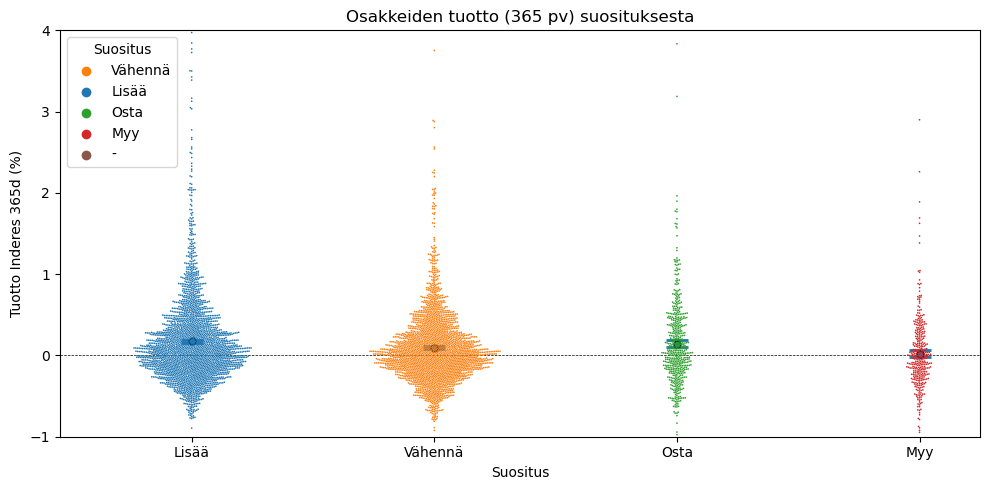

In [60]:
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

stat['mean 95% -'] = stat['mean'] - stat['mean 95% lower']
stat['mean 95% +'] = stat['mean 95% upper'] - stat['mean']

fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.swarmplot(ax=ax, data=interval1, x="Suositus", y='Tuotto Inderes 365d (%)', order=recs, size=1.2,
              hue='Suositus', palette=sns.color_palette(['#ff7f0e','#1f77b4','#2ca02c','#d62728','#8c564b']))
stat.loc[recs,'mean'].plot(marker='o', linestyle='', ax=ax, yerr=stat[['mean 95% -', 'mean 95% +']].T.values,
                  capsize=8, capthick=2, markeredgecolor='black', markersize=5)
ax.set_title('Osakkeiden tuotto (365 pv) suosituksesta')
ax.axhline(0.0, color='black', linestyle='dashed', linewidth=0.5)
ax.set_ylim(-1, 4)
fig.tight_layout()

In [61]:
# 1 year returns and their confidence interval from the recommendation day
stat = interval1.groupby('Suositus').apply(lambda trade: bootstrap_mean(trade['Tuotto Inderes 365d (%)']-
                                                                         trade['Tuotto Index 365d (%)'])).loc[recs,]
stat.round(3)

,mean,median,95% lower,95% upper,mean 95% lower,mean 95% upper
Suositus,,,,,,
Lisää,0.038,-0.028,-0.587,1.111,0.021,0.052
Vähennä,-0.062,-0.105,-0.671,0.819,-0.082,-0.045
Osta,0.046,-0.011,-0.573,0.902,0.011,0.087
Myy,-0.134,-0.167,-0.868,1.009,-0.174,-0.095


In [44]:
#TODO: +inderes effect is (1+'Tuotto (%)')(1+'Tuotto 365d')

In [63]:
# 1 year returns and their confidence interval from the recommendation day
stat = interval1.groupby('Suositus').apply(lambda trade: bootstrap_mean((1+trade['Tuotto Inderes 365d (%)'])* 
                                                                         (1+trade['Inderes (%)']) -
                                                                         (1+trade['Tuotto Index 365d (%)'])*
                                                                       (1+trade['Index (%)']))).loc[recs,]
stat.round(3)

,mean,median,95% lower,95% upper,mean 95% lower,mean 95% upper
Suositus,,,,,,
Lisää,0.049,-0.020,-0.585,1.166,0.033,0.069
Vähennä,-0.073,-0.109,-0.678,0.842,-0.089,-0.054
Osta,0.080,0.025,-0.567,1.036,0.038,0.115
Myy,-0.157,-0.190,-0.858,0.884,-0.198,-0.120


## Stock & Recommendation visualization

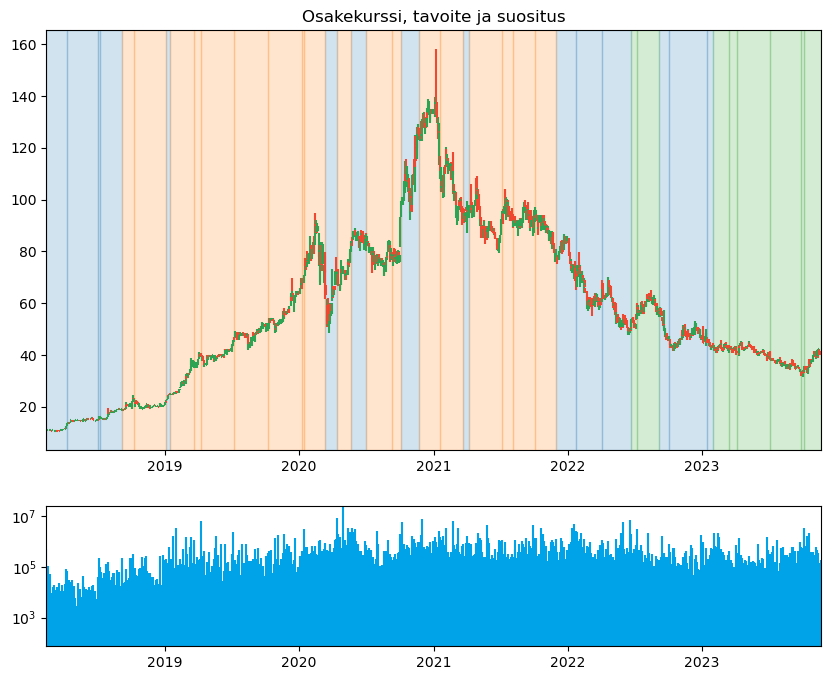

In [65]:
df_stock = prices[prices['Osake'] == 'Admicom']
interval_stock = interval1[interval1['Osake'] == 'Admicom']

ax1, ax2 = plot_ohlc(df_stock, time='Päivämäärä', open='Keskimäärin', close='Päätöskurssi', low='Alin', high='Ylin', 
                     volume='Vaihto €');
plot_recs(interval_stock, ax=ax, rec='Suositus', buy='Buy', sell='Sell')

In [66]:
def get_statistics(df):
    profit = (1+df['Tuotto Inderes (%)']).prod()
    index = (1+df['Tuotto Index (%)']).prod()
    days = df['Time'].sum()
    stats = pd.Series({
        'Tuotto Suositus': profit,
        'Tuotto Index': index,
        'CAGR Suositus': profit**(365/days) if days > 0 else 1.0,
        'CAGR Index': index**(365/days) if days > 0 else 1.0,
        'Pitoaika ': days,
    })
    return(stats)



In [67]:
pd.concat([
    interval_stock.groupby('Suositus').apply(get_statistics),
    pd.DataFrame({"Buy&Hold": get_statistics(interval_stock)}).transpose()],
axis=0)

,Tuotto Suositus,Tuotto Index,CAGR Suositus,CAGR Index,Pitoaika
Lisää,1.337250,1.129678,1.161383,1.064784,709.0
Osta,1.025337,0.817010,1.024991,0.819244,370.0
Vähennä,2.991469,1.466063,1.474479,1.145195,1030.0
Buy&Hold,4.101699,1.353114,1.276687,1.053731,2109.0
